In [1]:
import sys
import os

import pandas as pd
from sklearn import set_config
set_config(transform_output = "pandas")


# Custom utils
PROJECT_ROOT = '../'
MODEL_PATH = os.path.join(PROJECT_ROOT,'models','ANN')
sys.path.append(PROJECT_ROOT)
from scripts.data_utils import load_downsampled_df, load_full_df, get_train_validation_df, test_train_validation_split
from models.ANN.functions import get_preprocess_pipeline, load_h5

In [2]:
## Load and split data ##

main_df = load_downsampled_df(PROJECT_ROOT)
validation_df, test_train_df = get_train_validation_df(main_df)
X_train, X_test, X_validation, y_train, y_test, y_validation = test_train_validation_split(validation_df,test_train_df)
del main_df

In [3]:
## Create Preprocessing Pipeline ##

final_pipeline = get_preprocess_pipeline()

In [ ]:
# Fit preprocessing pipeline and save
from joblib import dump

X_train_processed = final_pipeline.fit_transform(X_train)
X_test_processed = final_pipeline.transform(X_test)

dump(final_pipeline,os.path.join(MODEL_PATH,'ANN_preprocess_pipeline.joblib'))

In [ ]:
# Load the model from hyperparmeter search

ANN_clf = load_h5(os.path.join(MODEL_PATH,'ANN.h5'))

**Visualizations**

In [14]:
from scripts.Visualization_functions import generate_visualizations, print_metrics, plot_roc_curve

In [13]:
# Get the validation dataset
main_df = load_full_df(PROJECT_ROOT)
validation_df, test_train_df = get_train_validation_df(main_df)
_, X_test, X_validation, _, y_test, y_validation = test_train_validation_split(validation_df,test_train_df)

In [16]:
## Load the model and pipeline
from joblib import load

preprocess_pipeline = load(os.path.join(MODEL_PATH,'ANN_preprocess_pipeline.joblib'))
ANN_clf = load_h5(os.path.join(MODEL_PATH,'ANN.h5'))

In [18]:
# Get Predictions
X_val_processed = preprocess_pipeline.transform(X_validation)
y_pred_proba = ANN_clf.predict(X_val_processed)

5637/5637 ━━━━━━━━━━━━━━━━━━━━ 3s 459us/step


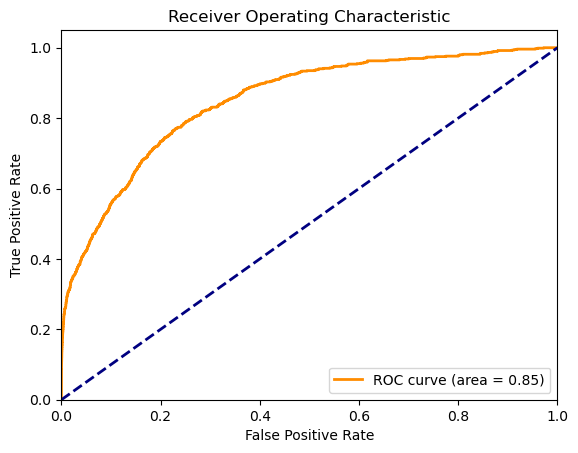

In [20]:
plot_roc_curve(y_validation, y_pred_proba)

In [ ]:
thresh = 0.5
y_val_pred = (y_pred_proba > thresh).astype(int)
generate_visualizations(X_val_processed,y_val_pred,y_validation,main_df,os.path.join(MODEL_PATH,"RF_Visuals"))

In [22]:
#y_val_pred = (y_pred_proba > 0.5).astype(int)
print_metrics(y_validation,y_val_pred)

Validation set accuracy: 0.9749516274789185
f1 score:  0.10250297973778308
Precision: 0.060252218589444184
Recall: 0.34308510638297873


In [ ]:
# Save validation probabilities
import numpy as np

np.save(os.path.join(MODEL_PATH,'ANN_y_val_proba.npy'),y_pred_proba)

**Hyperparameter and Model Tuning**

In [7]:
X_train_processed.keys()

Index(['numeric__fire_count_past_3Days', 'numeric__fire_count_past_30Days',
       'numeric__DMC', 'numeric__global_noon_LST_2m_temperature',
       'numeric__BUI', 'numeric__FWI', 'numeric__latitude', 'numeric__FFMC',
       'numeric__global_noon_LST_relative_humidity',
       'numeric__24hr_max_temperature',
       'numeric__global_noon_LST_2m_temperature_1dayLag',
       'numeric__global_noon_LST_2m_temperature_2dayLag',
       'numeric__high_vegetation_cover',
       'numeric__24hr_max_temperature_1dayLag',
       'numeric__low_vegetation_cover',
       'numeric__24hr_accumulated_precipitation', 'numeric__day_of_the_year',
       'categorical__type_of_high_vegetation_0',
       'categorical__type_of_high_vegetation_2',
       'categorical__type_of_high_vegetation_5',
       'categorical__type_of_high_vegetation_18',
       'categorical__type_of_high_vegetation_19',
       'pass__leaf_area_index_high_vegetation',
       'pass__slope_of_sub_gridscale_orography'],
      dtype='object'

In [11]:
## Initial Grid Search ##
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

from keras_tuner import Hyperband
import keras_tuner as kt
import tensorflow.keras.backend as K
from keras.metrics import AUC

#F1 scorer
f1 = make_scorer(f1_score , average='macro')

def ANN_classifier(hp):
    num_input_val=X_train_processed.shape[1]
    model = Sequential()
    model.Input_shape=(X_train_processed.shape[1],)
        # Tune the number of layers.
    for i in range(1,3):
        model.add(Dense(units=hp.Int(f'units_{i}',min_value=num_input_val,max_value=num_input_val*4,step=4),
            activation=hp.Choice(f'activation_{i}',['relu','tanh','sigmoid','swish','linear'])))
        if i>=2 and hp.Boolean("dropout"):# Tune whether to use dropout.
            model.add(layers.Dropout(rate=hp.Float(f'dropout{i}',min_value=0.2,max_value=0.5,sampling='linear')))

    # Define output layer
    model.add(Dense(1,activation='sigmoid'))

    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.AUC()])
    return model

tuner = kt.Hyperband(ANN_classifier,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=10,
                     factor=3,
                     executions_per_trial=2,
                     overwrite=False,
                     directory=os.path.join(MODEL_PATH,'ANN_Hyperband_tuning'),
                     project_name='ANN_R2')

tuner.search(X_train_processed, y_train, epochs=10, validation_data=(X_test_processed, y_test))


# Best parameters and best score
best_classifiers = tuner.get_best_models(num_models=1)
best_classifier=best_classifiers[0]
best_classifier.fit(x=X_train_processed, y=y_train, batch_size=64, epochs=5, verbose=1, validation_split=0.2)

best_classifier.save('ANN_selected parameters_RX.h5')

Trial 26 Complete [00h 01m 23s]
val_auc: 0.8516222536563873

Best val_auc So Far: 0.8570349216461182
Total elapsed time: 00h 18m 12s
Epoch 1/5


c:\Users\Home Office\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


850/850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.8588 - binary_accuracy: 0.8290 - loss: 0.3890 - val_auc: 0.8637 - val_binary_accuracy: 0.8292 - val_loss: 0.3840
Epoch 2/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.8620 - binary_accuracy: 0.8314 - loss: 0.3864 - val_auc: 0.8612 - val_binary_accuracy: 0.8318 - val_loss: 0.3863
Epoch 3/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.8626 - binary_accuracy: 0.8320 - loss: 0.3836 - val_auc: 0.8647 - val_binary_accuracy: 0.8306 - val_loss: 0.3821
Epoch 4/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.8607 - binary_accuracy: 0.8267 - loss: 0.3899 - val_auc: 0.8627 - val_binary_accuracy: 0.8294 - val_loss: 0.3851
Epoch 5/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.8576 - binary_accuracy: 0.8279 - loss: 0.3905 - val_auc: 0.8631 - val_binary_accuracy: 0.8288 - val_loss: 0.3851


In [12]:
#best_classifier.summary()
X_validation_processed = final_pipeline.transform(X_validation)

# Assuming predictions is the output of best_classifier.predict(X_validation_processed)
predictions = best_classifier.predict(X_validation_processed)

# Convert predictions to binary labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate the F1 score
f1_score_result = f1_score(y_validation, binary_predictions)

print('F1 score on validation data:', f1_score_result)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1 score on validation data: 0.618663594470046


In [13]:
best_classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 68)             │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 76)             │         5,244 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 76)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,065 (82.29 KB)

 Trainable params: 7,021 (27.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,044 (54.86 KB)